In [54]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix' # latex like
matplotlib.rcParams['font.family'] = 'STIXGeneral' # latex like

## Part 1

#### 1. Derive the corresponding Boundary Value Problem (BVP) for the displacement field u : [0, L]→R using the equilibrium equation for 1D problems (strong form).

Define variables

In [55]:
x = sp.Symbol('x',real=True)
u = sp.Function('u',real=True)(x)
u_xx = u.diff(x,2)
L, g, F, A, E = sp.symbols('L g F A E')
rho = sp.pi**3/L**2
s = g*sp.pi**4/L**2
r = (x/L)**2
b = g*sp.pi**2/L

Define the differential equation

In [56]:
ode = sp.Eq(u_xx + rho*u - s*r,0)
display(ode)

Eq(Derivative(u(x), (x, 2)) + pi**3*u(x)/L**2 - pi**4*g*x**2/L**4, 0)

---

#### 2. Find the exact solution of this BVP. Plot in a graph the solution of the problem using the following values of the involved constants and the function r = r(x/L):

Solve the differential equation

In [57]:
sol = sp.dsolve(ode, ics={u.subs(x,0):-g, u.diff(x).subs(x,L):b})
display(sol)

Eq(u(x), -2*g/pi**2 + (-pi**(7/2)*g + 2*pi**(3/2)*g - I*pi**4*g*exp(I*pi**(3/2)) + 2*I*pi**3*g*exp(I*pi**(3/2)))*exp(I*pi**(3/2)*x/L)/(pi**(7/2) + pi**(7/2)*exp(2*I*pi**(3/2))) + (-2*I*pi**3*g*exp(I*pi**(3/2)) + 2*pi**(3/2)*g*exp(2*I*pi**(3/2)) - pi**(7/2)*g*exp(2*I*pi**(3/2)) + I*pi**4*g*exp(I*pi**(3/2)))*exp(-I*pi**(3/2)*x/L)/(pi**(7/2) + pi**(7/2)*exp(2*I*pi**(3/2))) + pi*g*x**2/L**2)

In [58]:
# print(sol.free_symbols)
u_sol = sp.lambdify((x,L,g),sol.rhs)

In [59]:
x_range = np.linspace(0,1,100)
L, g = 1, 0.01

FileNotFoundError: [Errno 2] No such file or directory: 'figures/solution1.svg'

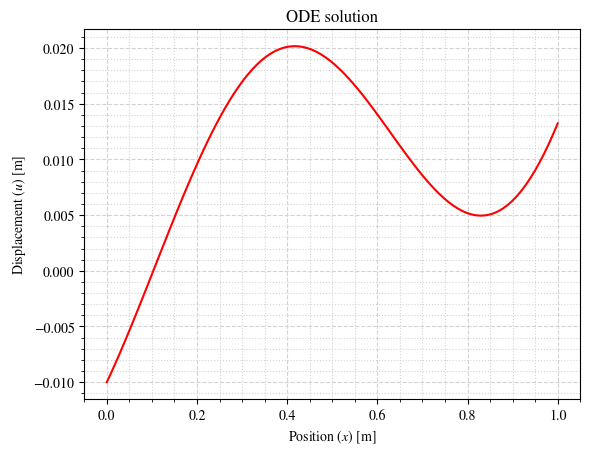

In [61]:
plt.title('ODE solution')
plt.plot(x_range,np.real(u_sol(x_range,L,g)), color='r')
plt.xlabel('Position ($x$) [m]')
plt.ylabel('Displacement ($u$) [m]')
plt.minorticks_on()
plt.grid(True, which='major', zorder=0, color='lightgray', linestyle='--')
plt.grid(True, which='minor', zorder=-1, color='lightgray', linestyle=':')
plt.savefig('figures/solution1.svg',format="svg")
plt.show()

---

#### 3. Formulate the Variational (or Weak) form of the Boundary Value Problem.

In [62]:
v = sp.Function('v')(x)
L,g = sp.symbols('L,g')
b = g*sp.pi**2/L
v_x = v.diff(x)
u_x = u.diff(x)
f = rho*u - s*r

In [63]:
v_x*u_x

Derivative(u(x), x)*Derivative(v(x), x)

In [64]:
weak_form = sp.Eq(sp.Integral(v_x*u_x,(x,0,L)),sp.Integral(v*f,(x,0,L)) + b*v.subs(x,1))
display(weak_form)

Eq(Integral(Derivative(u(x), x)*Derivative(v(x), x), (x, 0, L)), Integral((pi**3*u(x)/L**2 - pi**4*g*x**2/L**4)*v(x), (x, 0, L)) + pi**2*g*v(1)/L)

---

#### 4. Derive the corresponding matrix equation in terms of a generic matrix of basis functions N and their corresponding derivatives $B = \frac{dN(x)}{dx}$ .

In [11]:
# # Define a symbolic size 'n'
# n = sp.symbols('n', integer=True)
# # Define a symbolic row vector 'N' with 1 row and n columns
# N = sp.MatrixSymbol('N', 1, n)
# B = sp.MatrixSymbol('B', 1, n)
# c = sp.MatrixSymbol('c', n, 1)
# d = sp.MatrixSymbol('d', n, 1)
# v_x = B*c
# u_x = B*d
# v = N*c
# u = N*d

In [65]:
n = 3
# Create the symbols dynamically
c = sp.symbols(f'c_1:{n+2}')  # Generates c_1, c_2, ..., c_n
d = sp.symbols(f'd_1:{n+2}')  # Generates c_1, c_2, ..., c_n
c = sp.Matrix(c)
c[0] = 0
d = sp.Matrix(d)
# c = d = sp.Matrix([1 for i in range(n)])
N = sp.Matrix([x**i for i in range(n+1)]).T
B = N.diff()

In [66]:
K = sp.integrate(B.T*B,(x,0,L))
display(K)

Matrix([
[0,    0,        0,        0],
[0,    L,     L**2,     L**3],
[0, L**2, 4*L**3/3, 3*L**4/2],
[0, L**3, 3*L**4/2, 9*L**5/5]])

In [67]:
A = sp.integrate(rho*N.T*N,(x,0,L))
display(A)

Matrix([
[     pi**3/L,      pi**3/2,    pi**3*L/3, pi**3*L**2/4],
[     pi**3/2,    pi**3*L/3, pi**3*L**2/4, pi**3*L**3/5],
[   pi**3*L/3, pi**3*L**2/4, pi**3*L**3/5, pi**3*L**4/6],
[pi**3*L**2/4, pi**3*L**3/5, pi**3*L**4/6, pi**3*L**5/7]])

In [68]:
D = -((sp.integrate(s/L**2*N.T*x**2,(x,0,L))) - b*N.T.subs(x,1))
display(D)

Matrix([
[ -pi**4*g/(3*L) + pi**2*g/L],
[     -pi**4*g/4 + pi**2*g/L],
[   -pi**4*L*g/5 + pi**2*g/L],
[-pi**4*L**2*g/6 + pi**2*g/L]])

Equations:

In [123]:

r = 0
K_rr_Arr = K[r, r] - A[r, r]
K_ll_Arr = K[r+1:n,r+1:n] - A[r+1:n,r+1:n]
K_rl_Arr = K[r,r+1:n] - A[r,r+1:n]
K_lr_Arr =K[r+1:n,r] - A[r+1:n,r]

dr = d[r,:]
dl = d[r+1:n,:]
Dr = D[r,:]
Dl = D[r+1:n,:]

equation1 = sp.Eq(K_rr_Arr*dr + K_rl_Arr*dl, Dr)
equations2 = sp.Eq(K_lr_Arr*dr+K_ll_Arr* dl,Dl)
display(equation1)
display(equations2)



Eq(Matrix([[-pi**3*L*d_3/3 - pi**3*d_2/2 - pi**3*d_1/L]]), Matrix([[-pi**4*g/(3*L) + pi**2*g/L]]))

Eq(Matrix([
[            -pi**3*d_1/2 + d_2*(-pi**3*L/3 + L) + d_3*(-pi**3*L**2/4 + L**2)],
[-pi**3*L*d_1/3 + d_2*(-pi**3*L**2/4 + L**2) + d_3*(-pi**3*L**3/5 + 4*L**3/3)]]), Matrix([
[  -pi**4*g/4 + pi**2*g/L],
[-pi**4*L*g/5 + pi**2*g/L]]))